In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib
import seaborn
import numpy as np

#%matplotlib inline

In [2]:
# Import data from csv and compute some properties
csv  = pd.read_csv('runtimes.csv', sep = ';')

In [3]:
def mask(df, key, value):
    return df[df[key] == value].drop(key, axis = 1)

In [4]:
versions = ['vc_enabled', 'vc_disabled', 'vc_removed', 'clang.0', 'clang.1', 'clang.3', 'gcc.0', 'gcc.1', 'gcc.3', 'native']

pixels = { 
    'input1': '384 × 480 pixels',
    'input2': '512 × 288 pixels',
    'input3': '200 × 200 pixels',
    'input4': '220 × 334 pixels',
    'input5': '512 × 384 pixels',
    'input6': '250 × 184 pixels',
    'input7': '1350 × 900 pixels',
    'input7big': '6000 × 4000 pixels'
}

inputOrder = ['input3', 'input6', 'input4', 'input2', 'input1', 'input5', 'input7', 'input7big'] # by size
inputOrderIndex = dict(zip(inputOrder, range(len(inputOrder))))

#filters = ['id', 'smooth', 'emboss', 'blur', 'edges', 'sharpen']

In [5]:
def extract(filter, input, versions):
    sf = mask(mask(csv, 'input', input), 'filter', filter)

    sfs = []
    for v in versions:
        tmp = mask(sf, 'version', v).rename(columns = { 'runtime[ms]': v })
        tmp = tmp.reset_index(drop = True)
        sfs.append(tmp)

    fused = pd.concat(sfs, axis = 1)
    
    return fused

In [6]:
# generate boxplot for each input/filter combination, save as pdf
def genboxplots(file, versions, baselineVersion):
    pp = PdfPages(file)

    inputPrefix = 'input'
    for inputPostifx in ['1', '2', '3', '4', '5', '6', '7', '7big']:
        input = inputPrefix + inputPostifx
        fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 10))

        for filter, x, y in [('id', 0, 0), ('smooth', 0, 1), ('emboss', 0, 2), 
                             ('blur', 1, 0), ('edges', 1, 1), ('sharpen', 1, 2)]:
            subdata = extract(filter, input, versions)
            
            avgs = subdata.mean()
            baseline = avgs[baselineVersion]
            speedups = avgs.map(lambda x: baseline / x)
            
            # Display average speedups as numerical text above the boxes
            ax = axes[x, y]
            subdata.plot(kind = 'box', ax = ax)
            ax.set_title(filter, size = 'x-large')
            
            if y == 0:
                ax.set_ylabel('Runtime [ms]')
            ax.set_ylim(ymin = 0)
            labels = [ str(np.round(s, 2)) + 'x' for s in speedups ]
            _, top = ax.get_ylim()
            #ax.text(len(labels) / 2, top - (top * 0.05), 'speedups', size = 'large')
            for x, label in enumerate(labels):
                ax.text(x + 1, top - (top * 0.05), label, 
                        horizontalalignment = 'center', size = 'large')
            
        
        plt.suptitle('Runtimes & Speedups by kernels on {}: {}'.format(input, pixels[input]), 
                     fontsize = 'x-large', fontweight = 'bold')
        pp.savefig()
        plt.show()

    pp.close()

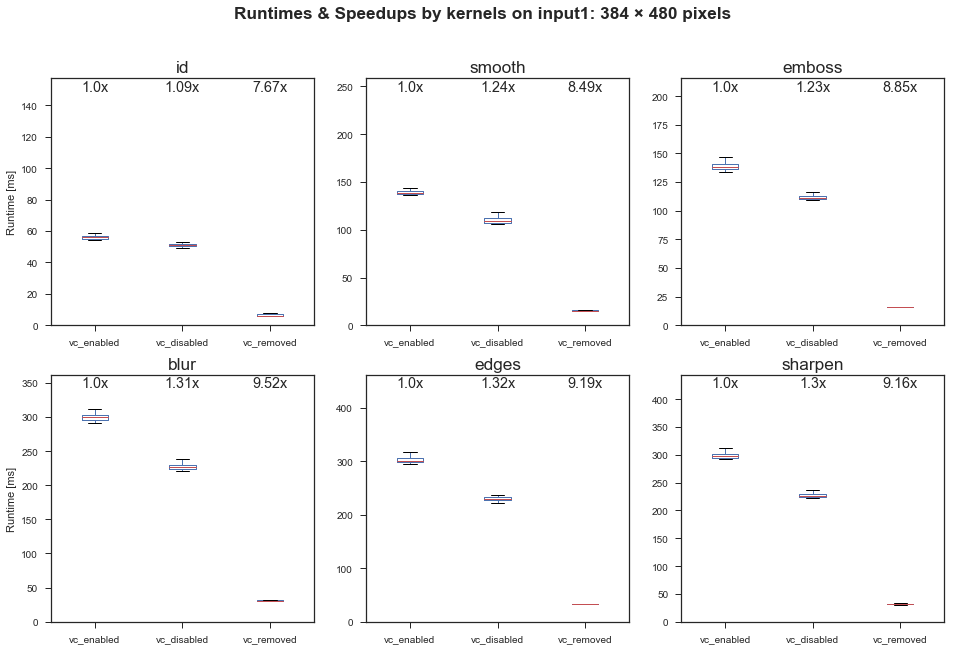

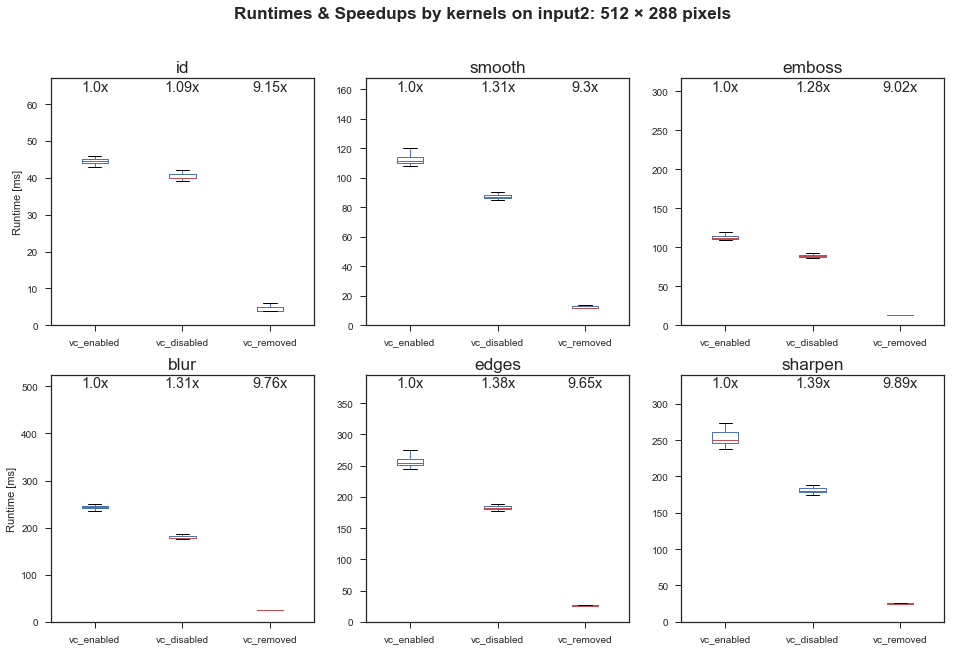

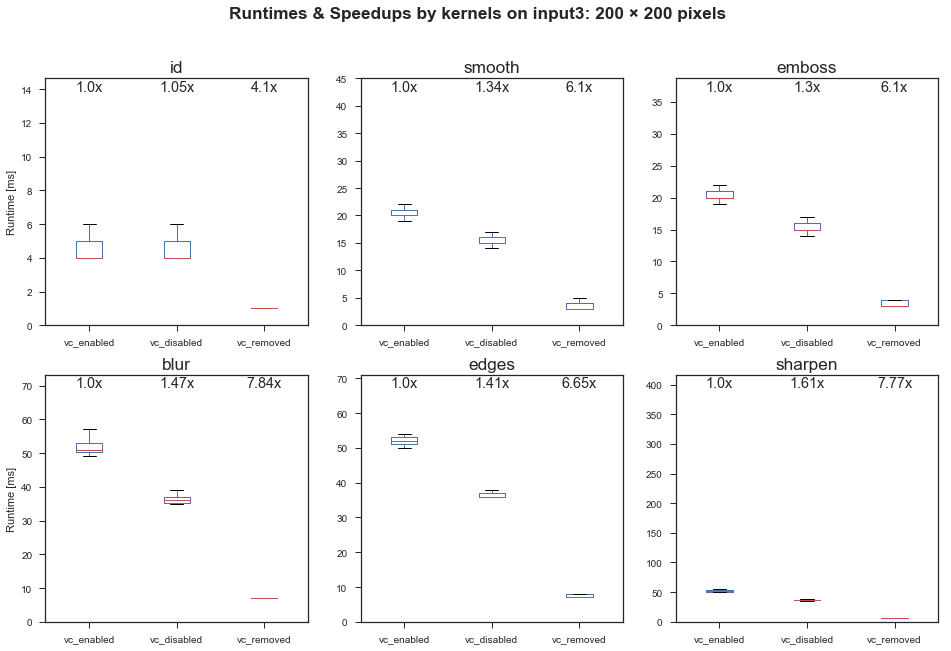

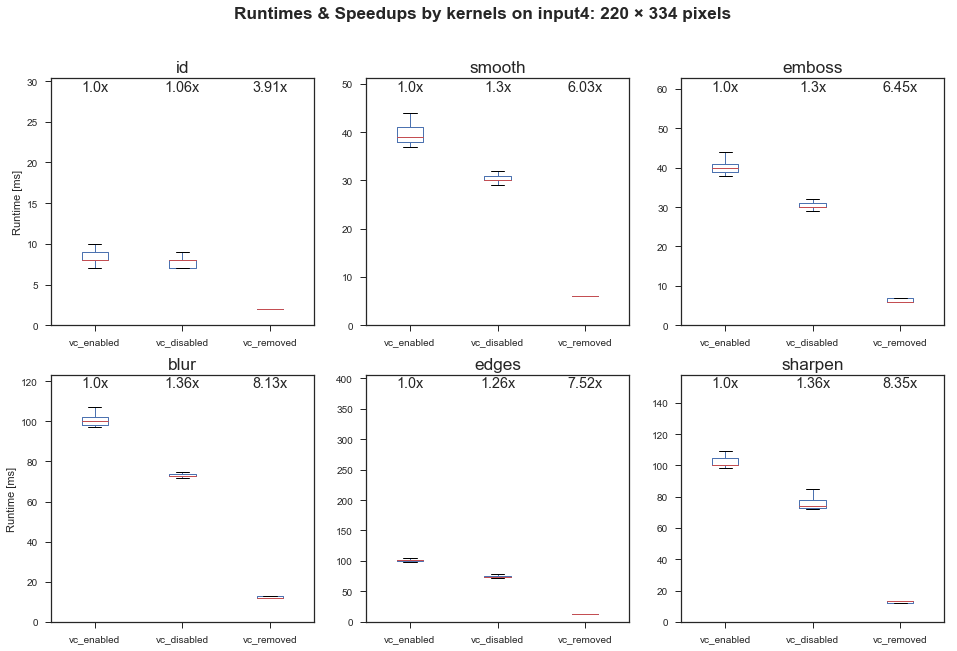

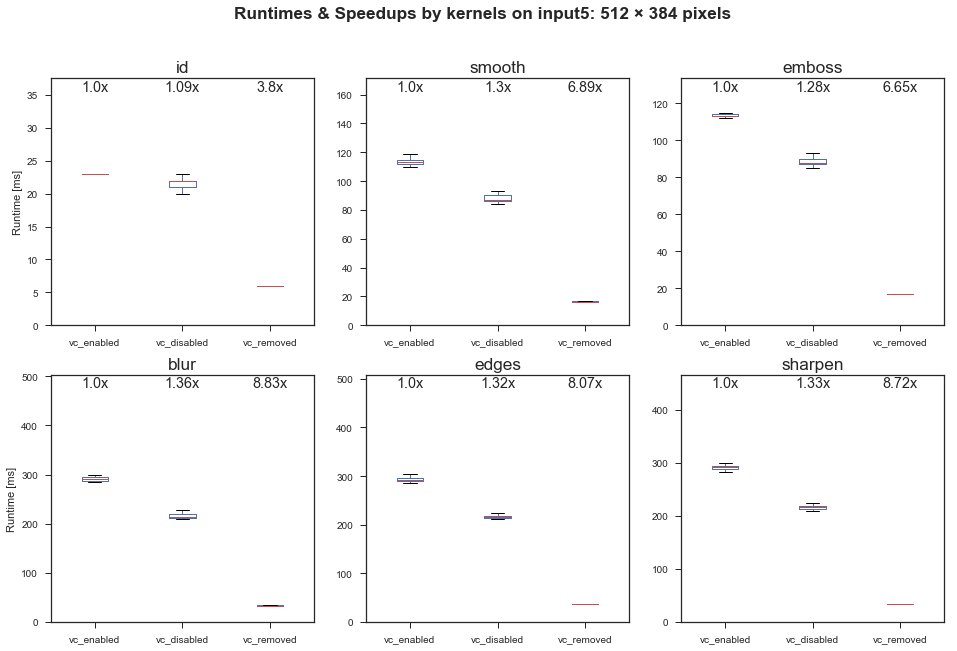

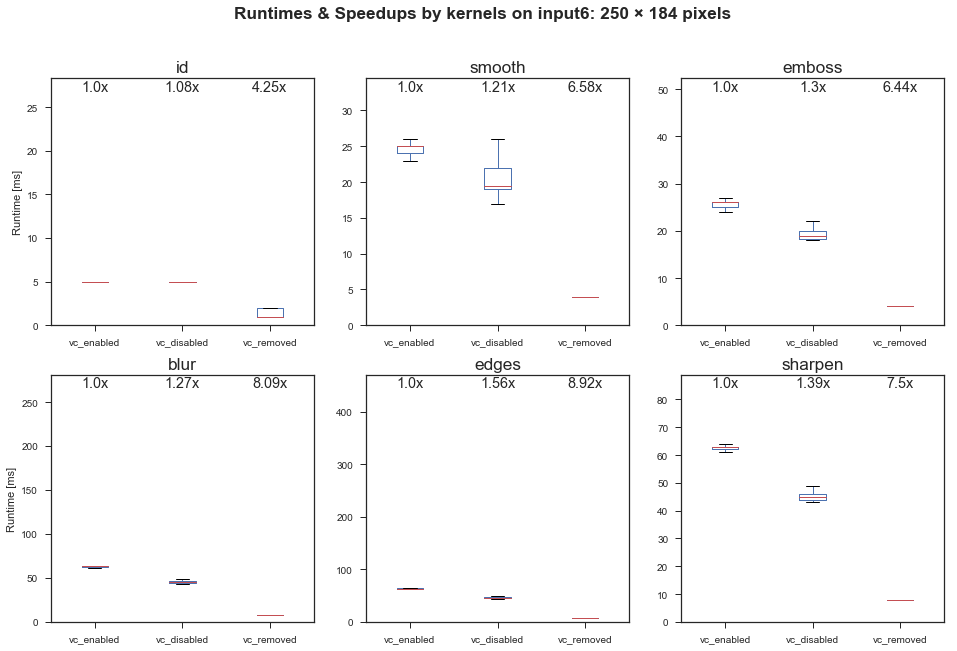

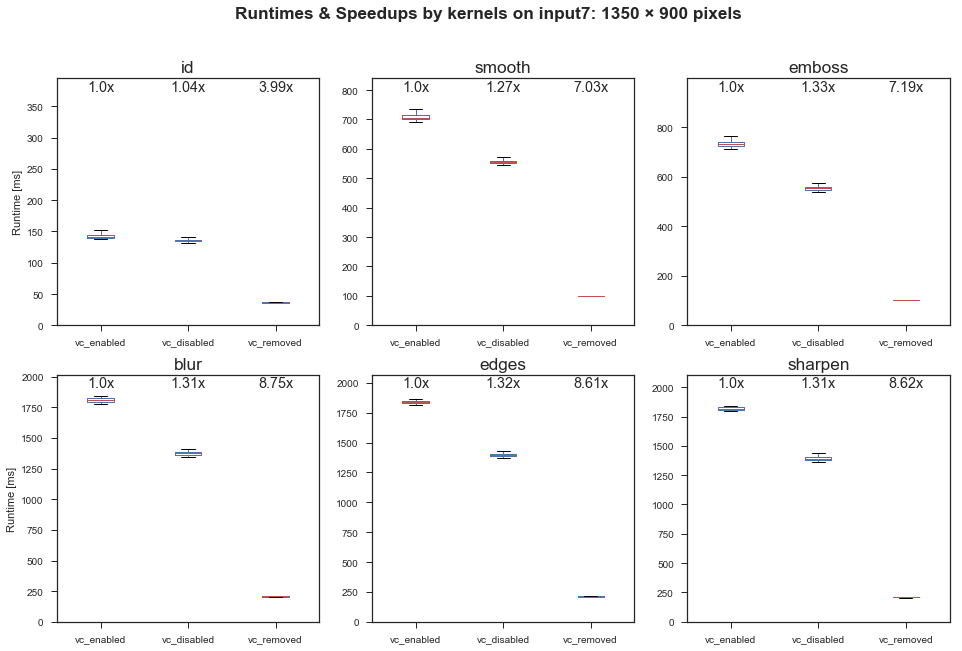

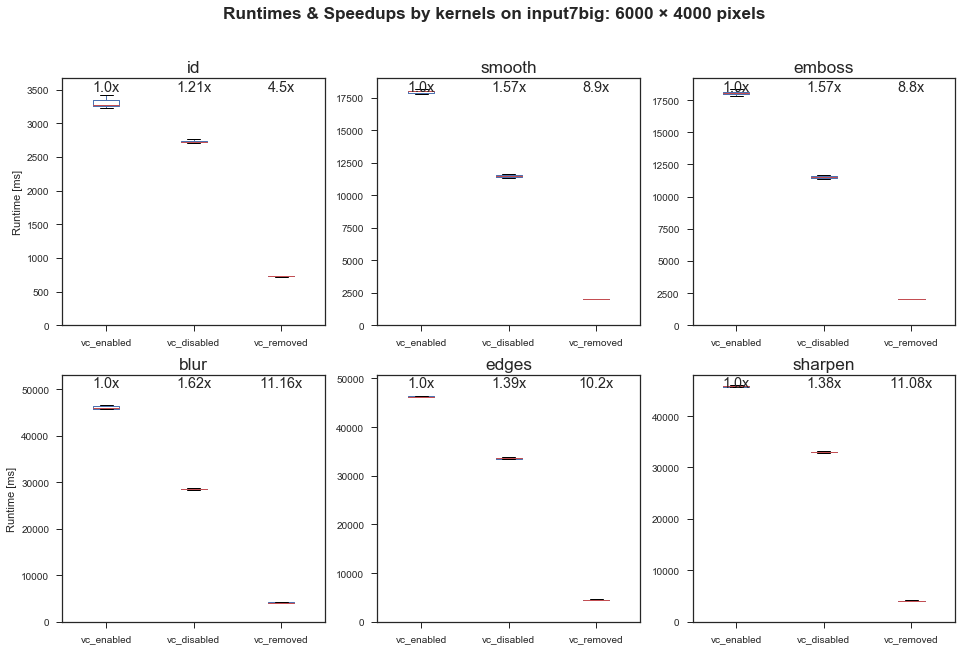

In [7]:
with plt.style.context(('seaborn-ticks')):
    genboxplots('plots_vcs.pdf', ['vc_enabled', 'vc_disabled', 'vc_removed'], 'vc_enabled')

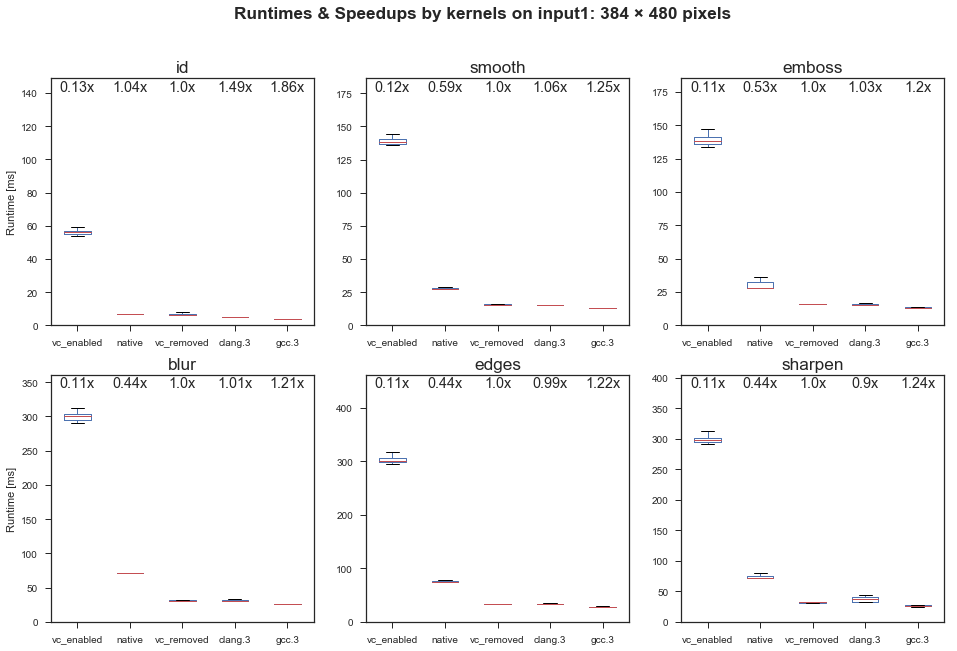

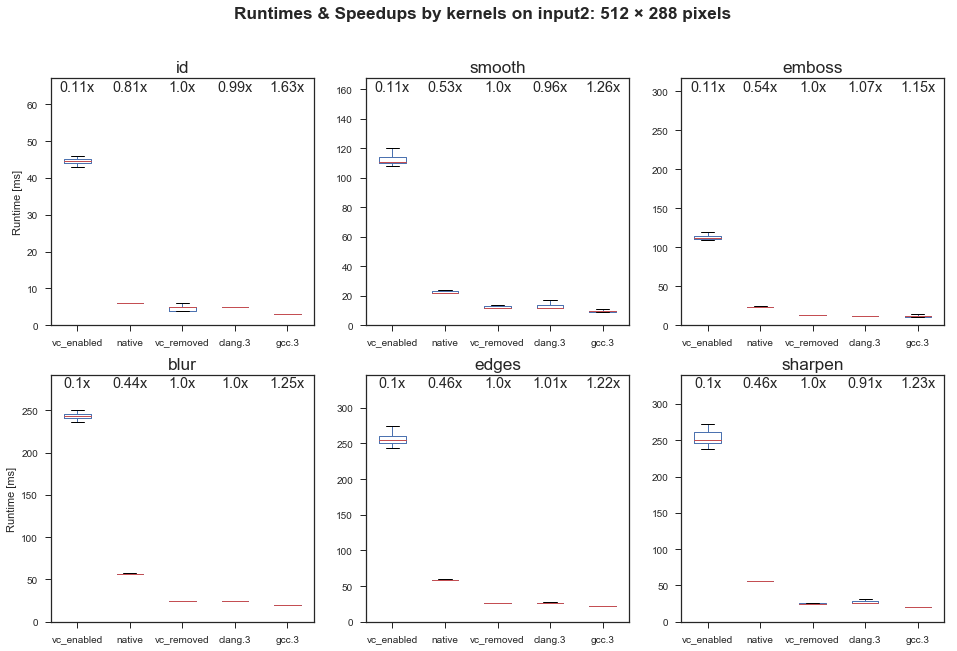

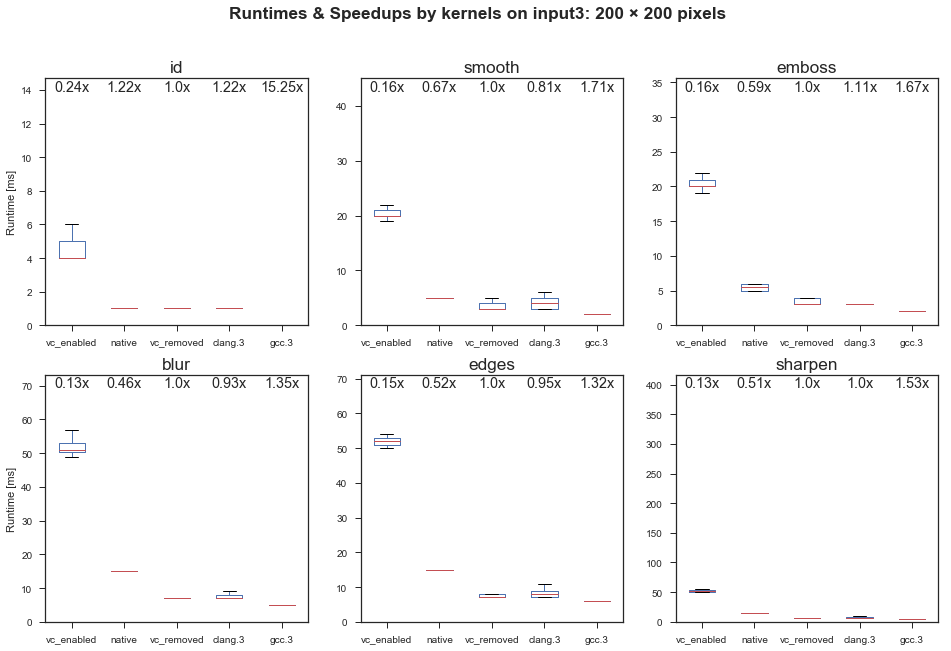

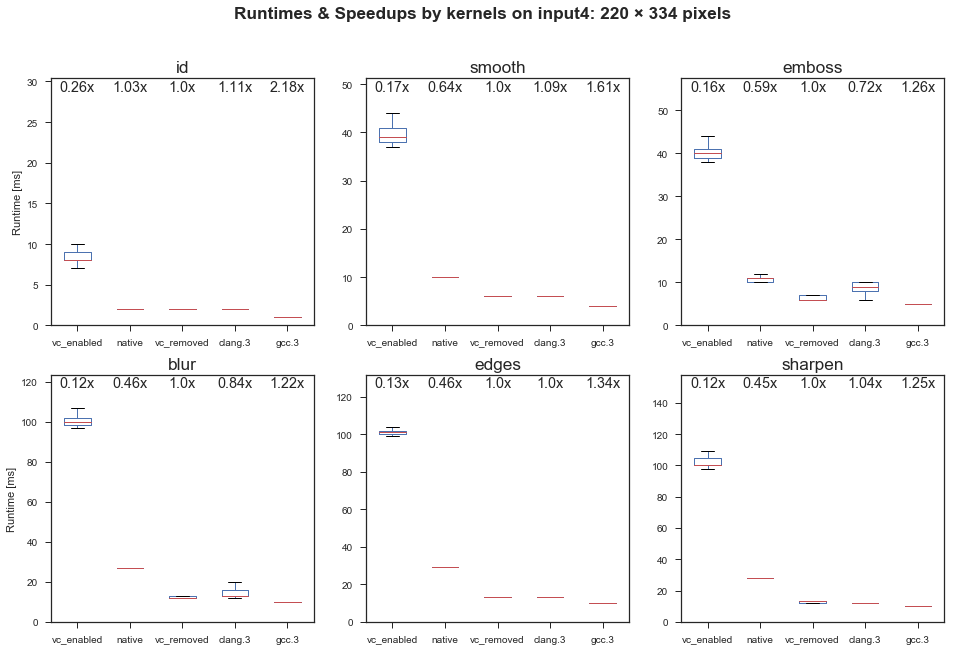

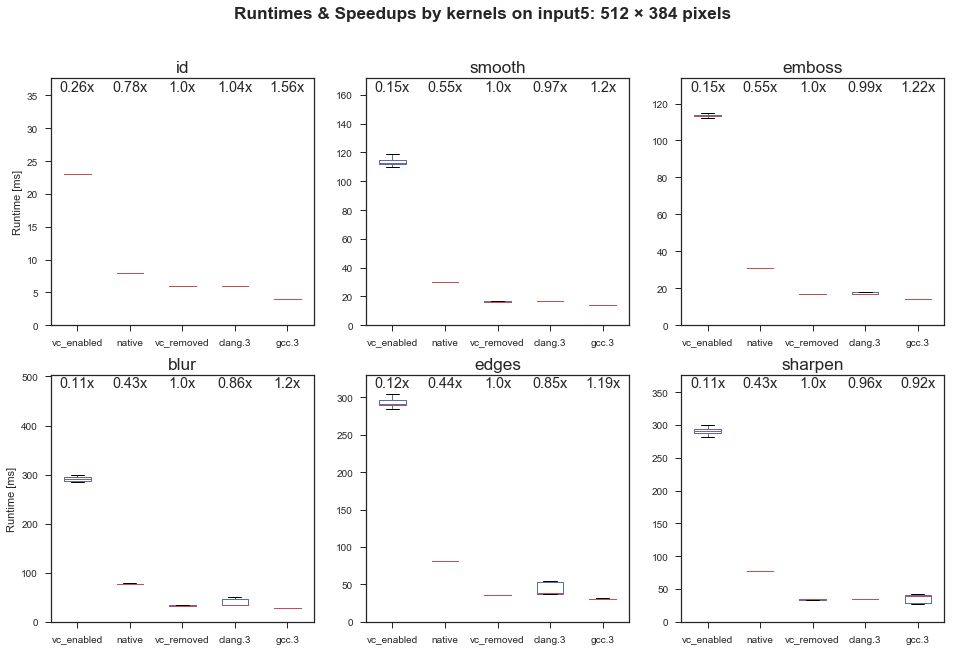

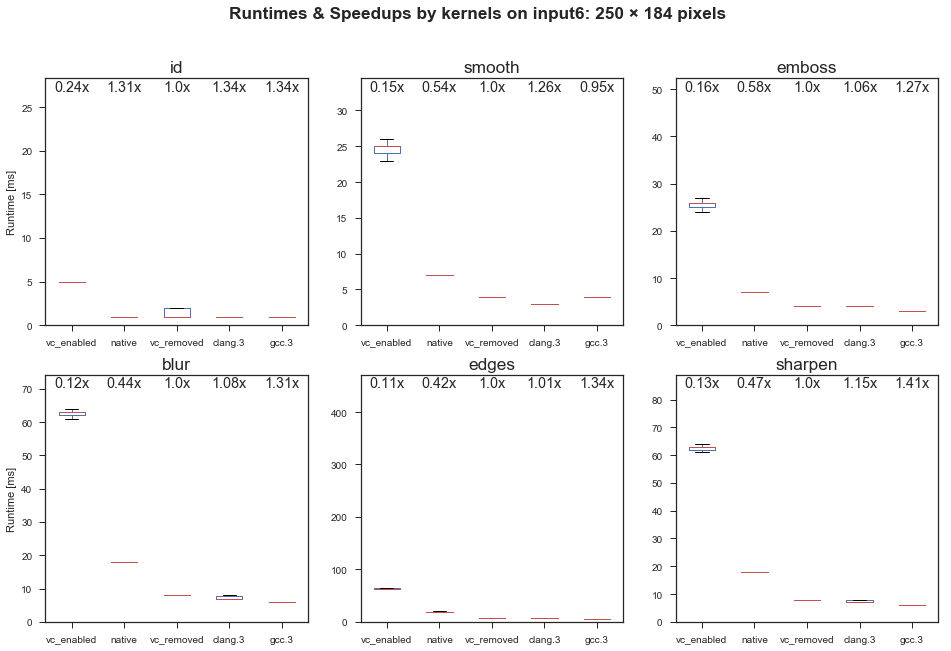

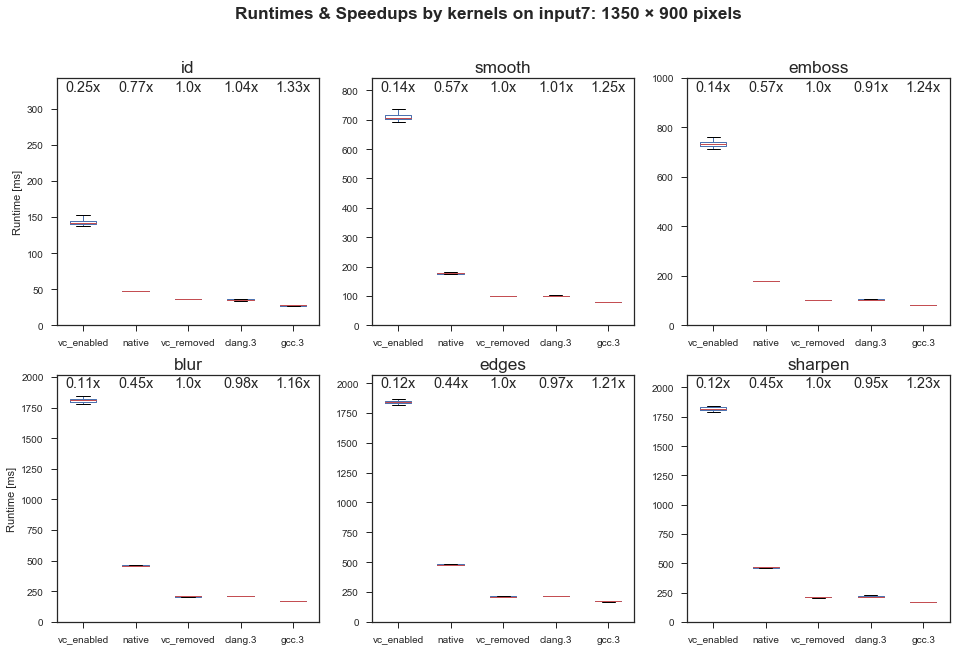

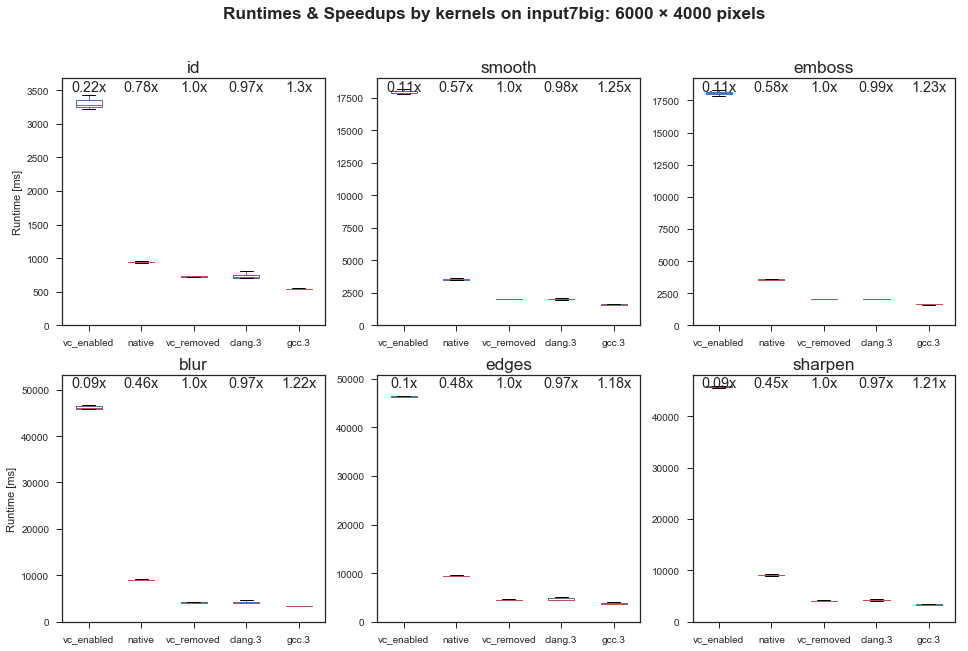

In [8]:
with plt.style.context(('seaborn-ticks')):
    genboxplots('plots.pdf', ['vc_enabled', 'native', 'vc_removed', 'clang.3', 'gcc.3'], 'vc_removed')

In [9]:
def plotSpeedupsByFilter(versions, baselineVersion, filter, ax):
    data = mask(csv, 'filter', filter)
    data = data[data['version'].isin(versions)].rename(columns = { 'runtime[ms]': 'runtime' })

    baselines = mask(data, 'version', baselineVersion).groupby(by = ['input'], as_index = True).mean()

    averages = data.groupby(by = ['version', 'input'], as_index = False).mean()
    averages['rank'] = averages['input'].map(inputOrderIndex)
    averages['speedup'] = averages.apply(lambda x: baselines.loc[x[1]]['runtime'] / x[2], axis = 1)
    averages = averages.sort_values(by = ['version', 'rank'])
    averages = averages.drop(['rank', 'runtime'], axis = 1)

    for i, group in averages.groupby(['version']):
        group.plot(kind = 'line', x = 'input', y = 'speedup', label = i, ax = ax)

def plotAllSpeedupsByFilter(versions, baselineVersion, file):
    pp = PdfPages(file)
    fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 10))
    
    for filter, x, y in [('id', 0, 0), ('smooth', 0, 1), ('emboss', 0, 2), 
                         ('blur', 1, 0), ('edges', 1, 1), ('sharpen', 1, 2)]:
        ax = axes[x, y]
        plotSpeedupsByFilter(versions, baselineVersion, filter, ax)
        ax.set_title(filter, size = 'x-large')
        if y == 0:
            ax.set_ylabel('Speedup')
        else:
            ax.set_ylabel('')
        ax.set_xlabel('')
    
    plt.suptitle('Speedups by kernel, with input sorted by size', 
                 fontsize = 'x-large', fontweight = 'bold')
    pp.savefig()
    plt.show()
        
    pp.close()

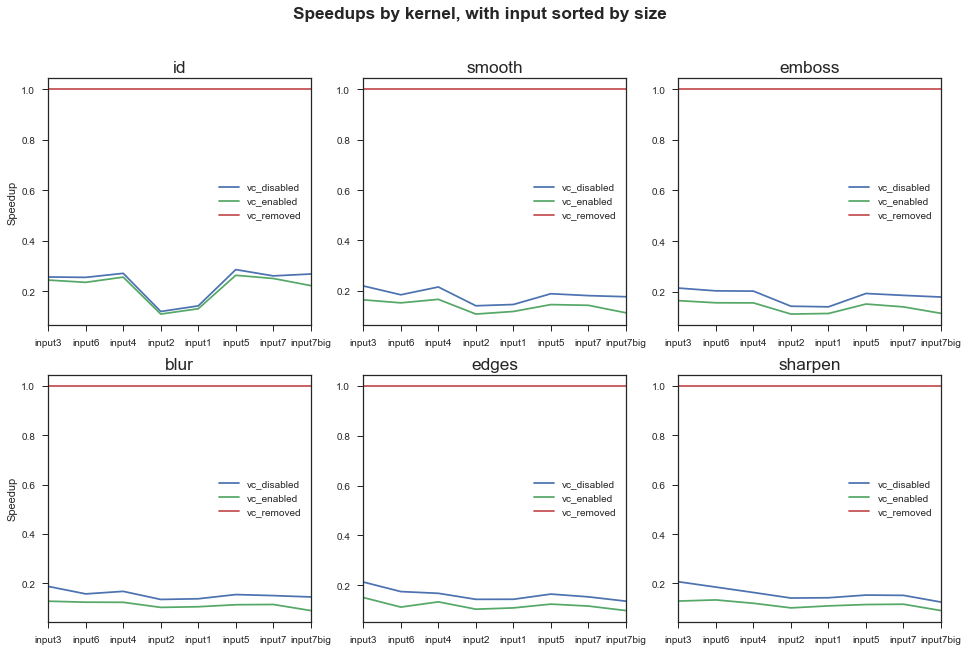

In [10]:
with plt.style.context(('seaborn-ticks')):
    plotAllSpeedupsByFilter(['vc_enabled', 'vc_disabled', 'vc_removed'], 'vc_removed', 'speedups_filters_vc.pdf')

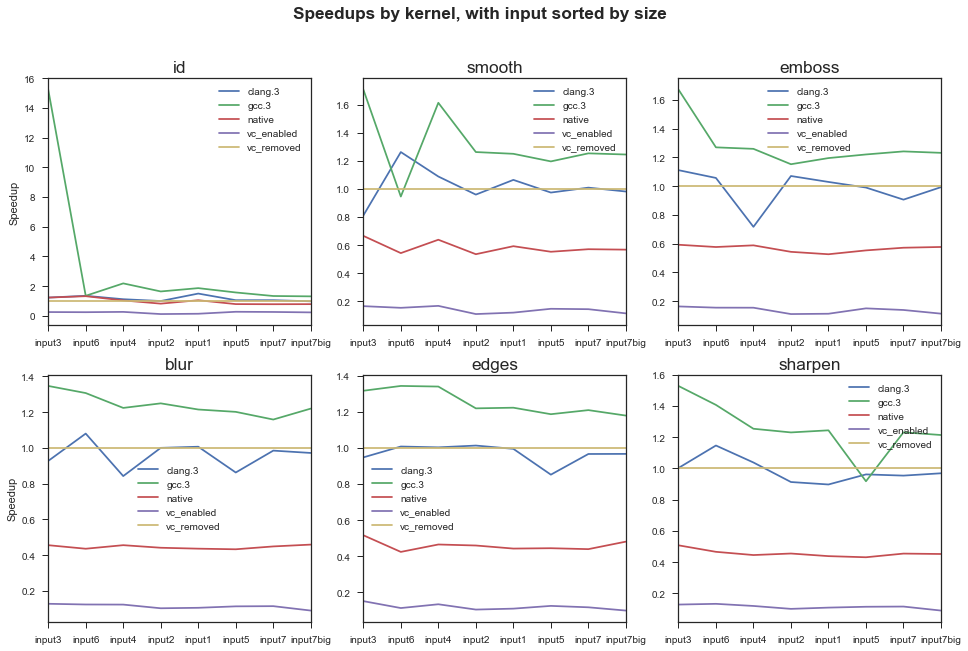

In [11]:
with plt.style.context(('seaborn-ticks')):
    plotAllSpeedupsByFilter(['vc_removed', 'vc_enabled', 'gcc.3', 'clang.3', 'native'], 'vc_removed', 'speedups_filters.pdf')